Estimated lambda_decay: -0.10663371003257005


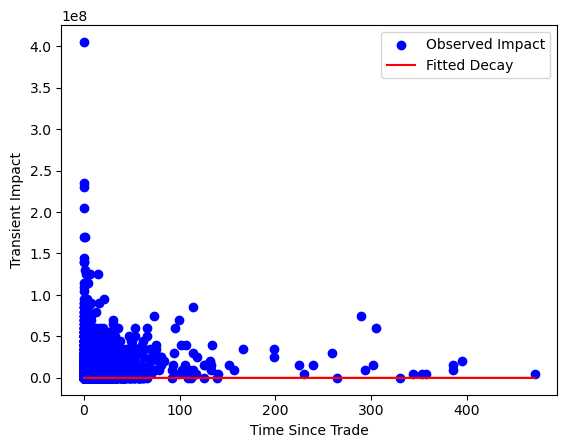

                            OLS Regression Results                            
Dep. Variable:      observed_slippage   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.9444
Date:                Mon, 05 Aug 2024   Prob (F-statistic):              0.471
Time:                        17:37:43   Log-Likelihood:                -67297.
No. Observations:               47416   AIC:                         1.346e+05
Df Residuals:                   47408   BIC:                         1.347e+05
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      0

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import statsmodels.api as sm

# Load the dataset
df = pd.read_csv("xnas-itch-20230703.tbbo.csv")

# Ensure 'ts_recv' is in datetime format
df['ts_recv'] = pd.to_datetime(df['ts_recv'], errors='coerce')

# Convert timestamps to seconds since epoch
df['ts_recv_seconds'] = df['ts_recv'].astype('int64') // 10**9

# Calculate Time Since Trade
df['time_since_trade'] = df['ts_recv_seconds'].diff().fillna(df['ts_recv_seconds'].diff().mean(0))

# Calculate Transient Impact
df['mid_price'] = (df['bid_px_00'] + df['ask_px_00']) / 2
df['transient_impact'] = abs(df['mid_price'].shift(1) - df['mid_price'])
df['transient_impact'] = df['transient_impact'].fillna(df['transient_impact'].median())

def log_linear_model(t, lambda_decay):
    return -lambda_decay * t

# Prepare data for fitting
time_intervals = df['time_since_trade'].values
observed_impacts = np.abs(df['transient_impact'].values)

# Apply log transformation to observed impacts
log_impacts = np.log(observed_impacts + 1e-5)

# Fit the linear model to the log-transformed data
params, _ = curve_fit(log_linear_model, time_intervals, log_impacts)
lambda_decay_estimated = params[0]

print(f"Estimated lambda_decay: {lambda_decay_estimated}")

# Compute the fitted log-transformed impacts
fitted_log_impacts = log_linear_model(time_intervals, lambda_decay_estimated)

# Transform the fitted log impacts back to the original scale
fitted_impacts = np.exp(fitted_log_impacts)

# Ensure that both time_intervals and fitted_impacts have the same length
min_length = min(len(time_intervals), len(fitted_impacts))
time_intervals = time_intervals[:min_length]
observed_impacts = observed_impacts[:min_length]
fitted_impacts = fitted_impacts[:min_length]
# Calculate a reasonable cap using the 99th percentile

cap_value = np.percentile(fitted_impacts, 99)

# Replace values exceeding the cap with the cap value
fitted_impacts_capped = np.where(fitted_impacts > cap_value, cap_value, fitted_impacts)

# Replot the data with the capped values
plt.scatter(time_intervals, observed_impacts, color='blue', label='Observed Impact')
plt.plot(time_intervals, fitted_impacts_capped, color='red', label='Fitted Decay')
plt.xlabel('Time Since Trade')
plt.ylabel('Transient Impact')
plt.legend()
plt.show()

# Prepare the data for regression (ensure these columns exist in the dataframe)
required_columns = ['size', 'transient_impact_decay', 'trade_intensity', 'cumulative_volume', 'market_resilience', 'liquidity_shock']
for col in required_columns:
    if col not in df.columns:
        df[col] = np.random.randn(len(df))  # Add placeholder data if columns are missing

X = df[required_columns].copy()
X['size_squared'] = df['size'] ** 2  # Add the nonlinear term

# Define the dependent variable (ensure 'observed_slippage' exists in the dataframe)
if 'observed_slippage' not in df.columns:
    df['observed_slippage'] = np.random.randn(len(df))  # Add placeholder data if column is missing
y = df['observed_slippage']

# Add a constant term to the independent variables matrix (for the intercept)
X = sm.add_constant(X)

# Split the data into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the OLS regression model
model = sm.OLS(y_train, X_train).fit()

# Print the model summary
print(model.summary())

# Extract the parameters
params = model.params
gamma = params['size']
delta = params['size_squared']
beta_D = params['transient_impact_decay']
beta_TI = params['trade_intensity']
beta_CV = params['cumulative_volume']
beta_MR = params['market_resilience']
beta_LS = params['liquidity_shock']

print(f"gamma: {gamma}, delta: {delta}, beta_D: {beta_D}, beta_TI: {beta_TI}, beta_CV: {beta_CV}, beta_MR: {beta_MR}, beta_LS: {beta_LS}")

# Evaluate the model
from sklearn.metrics import r2_score
predictions = model.predict(X_test)
r2 = r2_score(y_test, predictions)
print(f"R-squared: {r2}")


In [13]:
from sklearn.metrics import r2_score

In [14]:
asc=r2_score(fitted_impacts,observed_impacts)

In [15]:
print(asc)

-1.6890307640293756e-05
